In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot as plt
import tensorflow
import pandas as pd

In [2]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()
# 5 = Class 0, 7 = Class 1
x57_train = x_train[(y_train == 5) | (y_train == 7),]/255
y57_train = y_train[(y_train == 5) | (y_train == 7)]
y57_train = np.where(y57_train == 5, 0, 1).reshape((-1,1))

x57_test = x_test[(y_test == 5) | (y_test == 7),]/255
y57_test = y_test[(y_test == 5) | (y_test == 7)]
y57_test = np.where(y57_test == 5, 0, 1).reshape((-1,1))


In [10]:
savepath = './mnist57gan/'
# create discriminator
def discriminator(input_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# create generator
def generator(latent_dim):
    model = Sequential()
    # start from 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # increase resolution to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # increase resolution to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# create gan
def gan(g_model, d_model):
    # set discriminator to not trainable
    d_model.trainable = False
    # setup gan
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = tensorflow.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# select real samples
def gen_real(dataset, n_samples):
    # generate random indices for subsampling
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    # generate class labels == 1
    y = np.ones((n_samples, 1))
    return X, y

# generate latent input points
def getlatent(latent_dim, n_samples):
    # generate latent input points
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape to fit network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def gen_fake(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = getlatent(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=4):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(savepath + filename)
    plt.close()

# evaluate the discriminator, plot generated images, save generator model
def performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = gen_real(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = gen_fake(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    g_filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(savepath + g_filename)
    d_filename = 'discriminator_model_%03d.h5' % (epoch + 1)
    d_model.save(savepath + d_filename)

# train the generator and discriminator
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=200, n_batch=256, retries = 5):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs

    for r in range(retries):
        print(f'Try:{r}')
        d_model = discriminator()
        g_model = generator(latent_dim)
        gan_model = gan(g_model, d_model)
        
        d_loss_real = []
        d_loss_fake = []
        d_acc_real = []
        d_acc_fake = []

        g_loss = []
        g_loss_epoch = []
        g_loss_inc_counter = 0
        for i in range(n_epochs):
            print(f'Epoch: {i+1}')
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # get randomly selected 'real' samples
                X_real, y_real = gen_real(dataset, half_batch)
                # generate 'fake' examples
                X_fake, y_fake = gen_fake(g_model, latent_dim, half_batch)
                # create training set for the discriminator
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                # update discriminator model weights
                d_l_real, d_a_real = d_model.train_on_batch(X_real, y_real)
                d_l_fake, d_a_fake = d_model.train_on_batch(X_fake, y_fake)
                # prepare points in latent space as input for the generator
                X_gan = getlatent(latent_dim, n_batch)
                # create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_l = gan_model.train_on_batch(X_gan, y_gan)
                # summarize loss on this batch
                d_loss_real.append(d_l_real)
                d_loss_fake.append(d_l_fake)
                d_acc_real.append(d_a_real)
                d_acc_fake.append(d_a_fake)
                g_loss.append(g_l)
            print('Try:%d, Epoch:%d, dr=%.3f, df=%.3f, g=%.3f, d_racc=%.3f, d_facc=%.3f' % (r, i+1, d_l_real, d_l_fake, g_l, d_a_real, d_a_fake))
            g_loss_epoch.append(g_l)
            if len(g_loss_epoch) >= 2:
                if g_loss_epoch[-1] >  g_loss_epoch[-2]:
                    g_loss_inc_counter += 1
                    print(f'Generator loss increased for {g_loss_inc_counter} epochs.')
                elif g_loss_epoch[-1] <  g_loss_epoch[-2]:
                    g_loss_inc_counter = 0

            if g_loss_inc_counter == 5:
                print(f'Try: {r} failed to train. Restarting training')
                break
    #         evaluate the model performance, sometimes
            if (i+1) % 20 == 0:
                performance(i, g_model, d_model, dataset, latent_dim)
            
            if i == n_epochs - 1:
                return g_model, d_model, d_loss_real, d_loss_fake, d_acc_real, d_acc_fake, g_loss
        

In [11]:
latent_dim = 200
# d_model = discriminator()
# g_model = generator(latent_dim)
# gan_model = gan(g_model, d_model)
dataset = np.expand_dims(x57_train, axis = -1)
g_model, d_model, d_loss_real, d_loss_fake, d_acc_real, d_acc_fake, g_loss = train(generator, discriminator, gan, dataset, latent_dim)

Try:0
Epoch: 1
Try:0, Epoch:1, dr=0.097, df=0.669, g=0.721, d_racc=1.000, d_facc=1.000
Epoch: 2
Try:0, Epoch:2, dr=0.022, df=0.066, g=2.798, d_racc=1.000, d_facc=1.000
Generator loss increased for 1 epochs.
Epoch: 3
Try:0, Epoch:3, dr=0.144, df=0.243, g=1.608, d_racc=0.992, d_facc=1.000
Epoch: 4
Try:0, Epoch:4, dr=0.061, df=0.065, g=2.842, d_racc=0.984, d_facc=1.000
Generator loss increased for 1 epochs.
Epoch: 5
Try:0, Epoch:5, dr=0.018, df=0.023, g=3.866, d_racc=1.000, d_facc=1.000
Generator loss increased for 2 epochs.
Epoch: 6
Try:0, Epoch:6, dr=0.007, df=0.012, g=4.453, d_racc=1.000, d_facc=1.000
Generator loss increased for 3 epochs.
Epoch: 7
Try:0, Epoch:7, dr=0.006, df=0.008, g=4.849, d_racc=1.000, d_facc=1.000
Generator loss increased for 4 epochs.
Epoch: 8
Try:0, Epoch:8, dr=0.009, df=0.008, g=4.906, d_racc=1.000, d_facc=1.000
Generator loss increased for 5 epochs.
Try: 0 failed to train. Restarting training
Try:1
Epoch: 1
Try:1, Epoch:1, dr=0.105, df=0.659, g=0.733, d_racc=1

Try:1, Epoch:66, dr=0.692, df=0.692, g=0.712, d_racc=0.500, d_facc=0.562
Generator loss increased for 5 epochs.
Try: 1 failed to train. Restarting training
Try:2
Epoch: 1
Try:2, Epoch:1, dr=0.113, df=0.669, g=0.720, d_racc=1.000, d_facc=1.000
Epoch: 2
Try:2, Epoch:2, dr=0.025, df=0.096, g=2.443, d_racc=1.000, d_facc=1.000
Generator loss increased for 1 epochs.
Epoch: 3
Try:2, Epoch:3, dr=0.229, df=0.242, g=1.721, d_racc=0.977, d_facc=1.000
Epoch: 4
Try:2, Epoch:4, dr=0.068, df=0.061, g=2.904, d_racc=0.992, d_facc=1.000
Generator loss increased for 1 epochs.
Epoch: 5
Try:2, Epoch:5, dr=0.035, df=0.066, g=2.853, d_racc=1.000, d_facc=1.000
Epoch: 6
Try:2, Epoch:6, dr=0.023, df=0.025, g=3.749, d_racc=1.000, d_facc=1.000
Generator loss increased for 1 epochs.
Epoch: 7
Try:2, Epoch:7, dr=0.020, df=0.016, g=4.179, d_racc=0.992, d_facc=1.000
Generator loss increased for 2 epochs.
Epoch: 8
Try:2, Epoch:8, dr=0.015, df=0.012, g=4.523, d_racc=0.992, d_facc=1.000
Generator loss increased for 3 epo

Try:3, Epoch:63, dr=0.703, df=0.705, g=0.694, d_racc=0.508, d_facc=0.406
Epoch: 64
Try:3, Epoch:64, dr=0.696, df=0.699, g=0.693, d_racc=0.484, d_facc=0.508
Epoch: 65
Try:3, Epoch:65, dr=0.692, df=0.714, g=0.691, d_racc=0.492, d_facc=0.344
Epoch: 66
Try:3, Epoch:66, dr=0.680, df=0.706, g=0.694, d_racc=0.617, d_facc=0.406
Generator loss increased for 1 epochs.
Epoch: 67
Try:3, Epoch:67, dr=0.699, df=0.688, g=0.706, d_racc=0.461, d_facc=0.555
Generator loss increased for 2 epochs.
Epoch: 68
Try:3, Epoch:68, dr=0.689, df=0.697, g=0.695, d_racc=0.555, d_facc=0.484
Epoch: 69
Try:3, Epoch:69, dr=0.695, df=0.698, g=0.702, d_racc=0.422, d_facc=0.477
Generator loss increased for 1 epochs.
Epoch: 70
Try:3, Epoch:70, dr=0.692, df=0.692, g=0.705, d_racc=0.500, d_facc=0.562
Generator loss increased for 2 epochs.
Epoch: 71
Try:3, Epoch:71, dr=0.697, df=0.703, g=0.696, d_racc=0.508, d_facc=0.453
Epoch: 72
Try:3, Epoch:72, dr=0.689, df=0.690, g=0.707, d_racc=0.562, d_facc=0.500
Generator loss increased

Try:3, Epoch:138, dr=0.694, df=0.700, g=0.696, d_racc=0.531, d_facc=0.406
Generator loss increased for 1 epochs.
Epoch: 139
Try:3, Epoch:139, dr=0.694, df=0.693, g=0.696, d_racc=0.539, d_facc=0.484
Epoch: 140
Try:3, Epoch:140, dr=0.688, df=0.693, g=0.699, d_racc=0.594, d_facc=0.578
Generator loss increased for 1 epochs.
>Accuracy real: 69%, fake: 67%
Epoch: 141
Try:3, Epoch:141, dr=0.689, df=0.697, g=0.698, d_racc=0.555, d_facc=0.438
Epoch: 142
Try:3, Epoch:142, dr=0.693, df=0.692, g=0.698, d_racc=0.555, d_facc=0.508
Epoch: 143
Try:3, Epoch:143, dr=0.691, df=0.690, g=0.698, d_racc=0.508, d_facc=0.578
Generator loss increased for 1 epochs.
Epoch: 144
Try:3, Epoch:144, dr=0.697, df=0.689, g=0.703, d_racc=0.500, d_facc=0.586
Generator loss increased for 2 epochs.
Epoch: 145
Try:3, Epoch:145, dr=0.696, df=0.693, g=0.694, d_racc=0.438, d_facc=0.523
Epoch: 146
Try:3, Epoch:146, dr=0.689, df=0.699, g=0.696, d_racc=0.594, d_facc=0.391
Generator loss increased for 1 epochs.
Epoch: 147
Try:3, Ep

In [59]:
oraclepath = './oracles/mnist57.h5'
oracle = tensorflow.keras.models.load_model(oraclepath)
generatorpath = './mnist57gan/generator_model_200.h5'
gen = tensorflow.keras.models.load_model(generatorpath)

In [47]:
oracle.summary()

Model: "mnist57_oracle"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [48]:
t = getlatent(200,1000)
t2 = gen.predict(t)
t3 = np.repeat(t2, 3,axis = 3)
t4 = tensorflow.image.resize(t3, [32,32])
pred = oracle.predict(t4)

In [49]:
preds = np.squeeze(pred)
good = t4[(preds < 0.0000001) | (preds > 0.9999999)]
labs = preds[(preds < 0.0000001) | (preds > 0.9999999)]
labs = np.round(labs).astype('int')
len(labs)

549

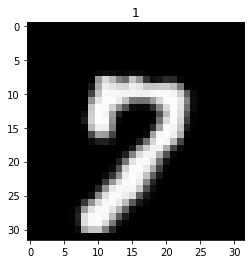

In [57]:
sel = np.squeeze(np.random.randint(0, good.shape[0], size = 1))
plt.imshow(good[sel])
plt.title(labs[sel])
plt.show()

In [55]:
labs

array([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,